In [3]:
import pandas as pd
import numpy as np


quotes = pd.read_csv("Grad_Scheme_Case_Study_Dataset.csv")
quotes.drop_duplicates(keep="first",inplace=True, ignore_index=True)


In [4]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
quotes["Driver1_DOB"] = pd.to_datetime(quotes["Driver1_DOB"]).apply(lambda x: relativedelta(datetime(2021,1,1),x).years)
quotes.rename(columns={"Driver1_DOB":"Driver1_Age"}, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15084\173628920.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  quotes["Driver1_DOB"] = pd.to_datetime(quotes["Driver1_DOB"]).apply(lambda x: relativedelta(datetime(2021,1,1),x).years)


In [5]:
quotes["Driver1_Convictions"].replace('-9999','No', inplace=True) #there are over a thousand, so I'm not dropping them
quotes["Driver1_Marital_Status"] = quotes["Driver1_Marital_Status"].apply(lambda x: x.title())
quotes.drop(columns=["Tax"], inplace=True)
quotes.drop(columns=["Days_to_Inception"],inplace=True)
quotes.drop(columns=["Capped_Premium"], inplace=True)
quotes["Driver1_Age"] -= quotes["Driver1_Licence_Years"]
quotes.rename(columns={"Driver1_Age":"Driver1_Age_Start_Licence"}, inplace=True)
quotes["Driver1_Convictions"]=pd.get_dummies(quotes["Driver1_Convictions"], drop_first=True)
quotes["Payment_Type"]=pd.get_dummies(quotes["Payment_Type"], drop_first=True)
quotes.rename(columns={quotes.columns[-2]:"Monthly"}, inplace=True)
quotes.drop(columns=["Quote_ID", "Quote_Date"], inplace=True)
quotes = quotes[(quotes["Vehicle_Value"]>=0) & (20000 > quotes["Vehicle_Annual_Mileage"]) & (quotes["Vehicle_Annual_Mileage"]>=0) & (75 > quotes["Vehicle_Age"]) & (quotes["Vehicle_Age"]>=0)]


# Single Drivers

In [6]:
single_drivers = quotes[(quotes["Driver2_Licence_Type"].isna()) & (quotes["Driver2_Licence_Years"].isna())].drop(columns=["Driver2_Licence_Type", "Driver2_Licence_Years"], inplace=False)
single_drivers

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
0,27.0,Full UK,34.0,False,0,Married,4,24178,12849.0,240,True,707.64
1,31.0,Full UK,12.0,False,2,Married,14,1744,1250.0,200,False,1176.96
14,17.0,Full UK,25.0,False,2,Divorced,10,3270,1193.0,669,True,334.98
16,17.0,Full UK,32.0,False,0,Separated,13,4481,4930.0,396,False,1839.00
23,31.0,Full UK,18.0,False,0,Divorced,7,5065,4385.0,791,False,264.21
...,...,...,...,...,...,...,...,...,...,...,...,...
49607,20.0,Full UK,34.0,False,0,Divorced,5,6552,4103.0,732,False,528.03
49608,27.0,Full UK,0.0,False,3,Married,7,4698,6770.0,225,True,2135.49
49618,33.0,Full UK,23.0,False,2,Single,20,403,1102.0,784,False,923.13
49625,18.0,Automatic,10.0,True,3,Single,6,10994,9100.0,710,True,1521.78


In [7]:
single_drivers["Vehicle_Age"].corr(single_drivers["Vehicle_Value"]) #high correlation

-0.7168826058672378

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(single_drivers[["Driver1_Age_Start_Licence", "Driver1_Licence_Years", "Driver1_Claims", "Vehicle_Age", "Vehicle_Annual_Mileage", "Credit_Score"]])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns) 
# when I drop Vehicle value every vif's around 1
single_drivers.drop(columns = ["Vehicle_Value"], inplace = True)

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
single_drivers["Driver1_Licence_Type"]=le.fit_transform(single_drivers["Driver1_Licence_Type"])
single_drivers["Driver1_Marital_Status"]=le.fit_transform(single_drivers["Driver1_Marital_Status"])

In [10]:
from sklearn.model_selection import train_test_split
#from scipy import stats
#single_no_out = single_drivers[np.abs(stats.zscore(single_drivers["Premium"]))<3] #might be better to do it fro each group, but in any case I'm not doing it yet
#X,y = single_no_out.iloc[:,:-1], single_no_out.iloc[:,-1]
X,y = single_drivers.iloc[:,:-1], single_drivers.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train.max(), y_test.max()

(19968.44, 19607.17)

In [11]:
from xgboost import XGBRegressor
#from sklearn.model_selection import RepeatedKFold
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = XGBRegressor(eta=0.99, max_depth = 10)


In [12]:
model.fit(X,y)  

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.99, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [13]:
model.score(X_train,y_train),model.score(X_test,y_test)

(0.9999989633894103, 0.9999990978685329)

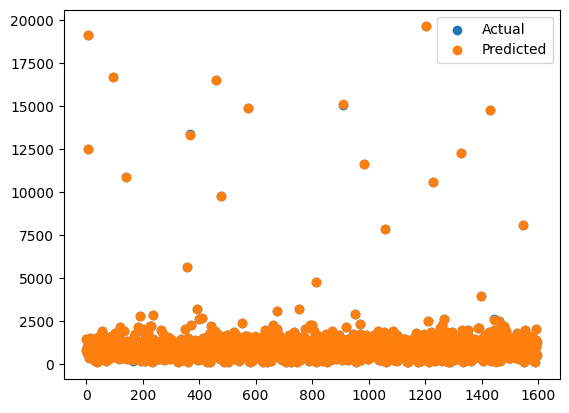

In [14]:
import matplotlib.pyplot as plt
y_predict = model.predict(X_test)
plt.scatter(np.arange(len(y_predict)), y_test, label = "Actual")
plt.scatter(np.arange(len(y_predict)), y_predict, label = "Predicted")
plt.legend()
plt.show()

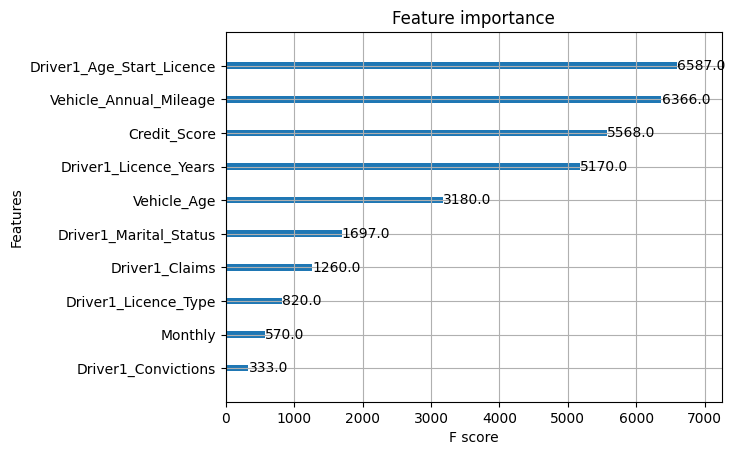

In [17]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

# 2 drivers

In [18]:
two_drivers =quotes[~((quotes["Driver2_Licence_Type"].isna()) & (quotes["Driver2_Licence_Years"].isna()))]
two_drivers

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
3,23.0,Full UK,17.0,Full UK,NaN,False,2,Married,6,12569,12266.0,548,False,1282.56
4,18.0,Full UK,25.0,Full UK,NaN,False,0,Separated,8,11395,11117.0,393,False,1471.02
5,19.0,Full UK,45.0,Automatic,20.0,False,2,Married,5,6172,3589.0,689,True,730.98
6,21.0,Full UK,1.0,Provisional UK,22.0,False,0,Widowed,9,2303,2239.0,706,True,1443.33
7,35.0,Full UK,27.0,Automatic,13.0,False,0,Single,10,6574,3581.0,785,True,642.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49636,18.0,Full UK,12.0,NaN,24.0,False,0,Other,14,1633,1074.0,397,False,451.50
49637,27.0,Full UK,1.0,Full UK,25.0,False,0,Married,6,8050,2987.0,158,True,1375.59
49638,18.0,Automatic,13.0,NaN,24.0,False,0,Civil Partnership,8,11124,3364.0,328,False,1207.05
49639,71.0,Full UK,0.0,Provisional UK,11.0,False,0,Single,3,10821,9303.0,277,True,1776.93


In [19]:
two_drivers["Vehicle_Age"].corr(two_drivers["Vehicle_Value"])

-0.7265833667208137

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(two_drivers[["Driver1_Age_Start_Licence", "Driver1_Licence_Years", "Driver1_Claims", "Vehicle_Age", "Vehicle_Annual_Mileage", "Credit_Score"]])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns) 
# when I drop Vehicle value every vif's around 1
two_drivers.drop(columns = ["Vehicle_Value"], inplace = True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15084\3025827105.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers.drop(columns = ["Vehicle_Value"], inplace = True)


In [21]:
two_drivers.groupby("Driver2_Licence_Type")["Driver2_Licence_Years"].mean() #fill each group with its mean
# Full Non EU/EEC has only NaN values, so fill with overall mean (and there are only two of them)

Driver2_Licence_Type
Automatic             20.759259
Full EU/EEC           18.777778
Full International    19.163265
Full Non EU/EEC             NaN
Full UK               22.366933
Provisional UK        20.581522
Name: Driver2_Licence_Years, dtype: float64

In [22]:
two_drivers[two_drivers["Driver2_Licence_Type"] == "Full Non EU/EEC"]

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
726,32.0,Provisional UK,39.0,Full Non EU/EEC,NaN,True,0,Civil Partnership,10,1435.0,767,True,489.24
14863,19.0,Provisional UK,17.0,Full Non EU/EEC,NaN,True,1,Married,16,1026.0,239,True,978.03


In [23]:
two_drivers["Driver2_Licence_Years"] = two_drivers.groupby("Driver2_Licence_Type", dropna=False)["Driver2_Licence_Years"].transform(lambda x: x.fillna(x.mean())) #by default groupby drops NaN and I don't want to lose nan driver licence with years


C:\Users\Usuario\AppData\Local\Temp\ipykernel_15084\2259414229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers["Driver2_Licence_Years"] = two_drivers.groupby("Driver2_Licence_Type", dropna=False)["Driver2_Licence_Years"].transform(lambda x: x.fillna(x.mean())) #by default groupby drops NaN and I don't want to lose nan driver licence with years


In [24]:
two_drivers["Driver2_Licence_Years"].fillna(two_drivers["Driver2_Licence_Years"].mean(), inplace=True)
two_drivers

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15084\854736404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers["Driver2_Licence_Years"].fillna(two_drivers["Driver2_Licence_Years"].mean(), inplace=True)


,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
3,23.0,Full UK,17.0,Full UK,22.366933,False,2,Married,6,12266.0,548,False,1282.56
4,18.0,Full UK,25.0,Full UK,22.366933,False,0,Separated,8,11117.0,393,False,1471.02
5,19.0,Full UK,45.0,Automatic,20.000000,False,2,Married,5,3589.0,689,True,730.98
6,21.0,Full UK,1.0,Provisional UK,22.000000,False,0,Widowed,9,2239.0,706,True,1443.33
7,35.0,Full UK,27.0,Automatic,13.000000,False,0,Single,10,3581.0,785,True,642.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49636,18.0,Full UK,12.0,NaN,24.000000,False,0,Other,14,1074.0,397,False,451.50
49637,27.0,Full UK,1.0,Full UK,25.000000,False,0,Married,6,2987.0,158,True,1375.59
49638,18.0,Automatic,13.0,NaN,24.000000,False,0,Civil Partnership,8,3364.0,328,False,1207.05
49639,71.0,Full UK,0.0,Provisional UK,11.000000,False,0,Single,3,9303.0,277,True,1776.93


In [25]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
two_drivers["Driver1_Licence_Type"]=le.fit_transform(two_drivers["Driver1_Licence_Type"])
two_drivers["Driver2_Licence_Type"]=le.fit_transform(two_drivers["Driver2_Licence_Type"])
two_drivers["Driver1_Marital_Status"]=le.fit_transform(two_drivers["Driver1_Marital_Status"])
two_drivers

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15084\2975542393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers["Driver1_Licence_Type"]=le.fit_transform(two_drivers["Driver1_Licence_Type"])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15084\2975542393.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers["Driver2_Licence_Type"]=le.fit_transform(two_drivers["Driver2_Licence_Type"])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15084\2975542393.py:5: SettingWithCopyWarning: 
A value 

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
3,23.0,2,17.0,4,22.366933,False,2,3,6,12266.0,548,False,1282.56
4,18.0,2,25.0,4,22.366933,False,0,5,8,11117.0,393,False,1471.02
5,19.0,2,45.0,0,20.000000,False,2,3,5,3589.0,689,True,730.98
6,21.0,2,1.0,5,22.000000,False,0,7,9,2239.0,706,True,1443.33
7,35.0,2,27.0,0,13.000000,False,0,6,10,3581.0,785,True,642.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49636,18.0,2,12.0,6,24.000000,False,0,4,14,1074.0,397,False,451.50
49637,27.0,2,1.0,4,25.000000,False,0,3,6,2987.0,158,True,1375.59
49638,18.0,0,13.0,6,24.000000,False,0,0,8,3364.0,328,False,1207.05
49639,71.0,2,0.0,5,11.000000,False,0,6,3,9303.0,277,True,1776.93


In [26]:
X,y = two_drivers.iloc[:,:-1], two_drivers.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train.max(), y_test.max()

(19914.14, 19946.7)

In [27]:
model = XGBRegressor(eta=0.99, max_depth = 15)
model.fit(X,y)  
model.score(X_train,y_train),model.score(X_test,y_test)

(0.9999999991507768, 0.9999999989956241)

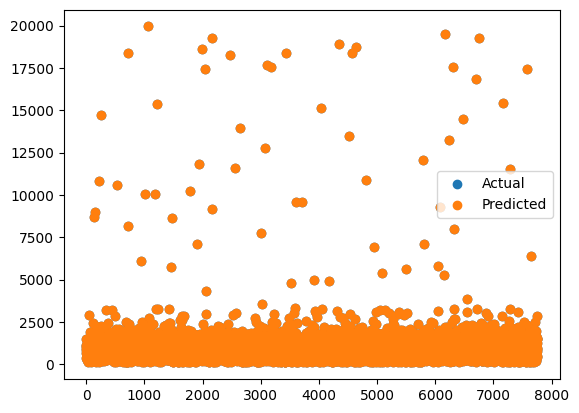

In [28]:
import matplotlib.pyplot as plt
y_predict = model.predict(X_test)
plt.scatter(np.arange(len(y_predict)), y_test, label = "Actual")
plt.scatter(np.arange(len(y_predict)), y_predict, label = "Predicted")
plt.legend()
plt.show()

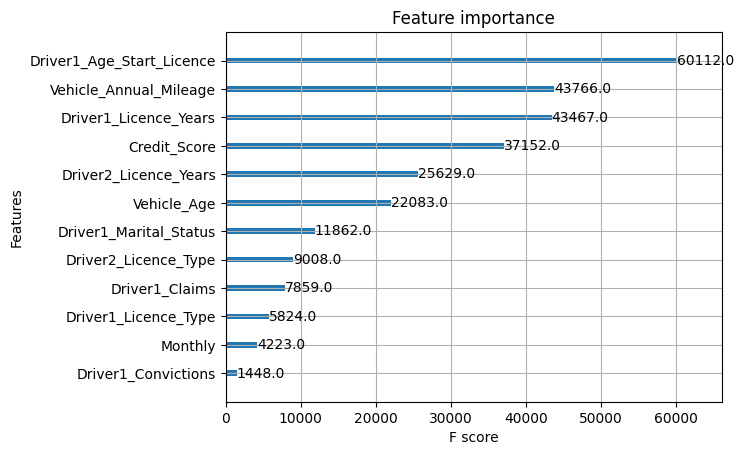

In [30]:
plot_importance(model)
plt.show()